여기서는 이미지를 openCV를 활용하여 자르고, 정확한 bbox를 구한다.</br>
그 뒤, 각 이미지마다 bbox 기준으로 자른 후 224x224 크기의 투명 이미지의 중앙에 합성하여 분류기용 이미지로 만든다.</br>
분류기용 이미지들을 해당하는 폴더들로 수작업으로 분류해준다.</br>
</br>
분류가 완료되면 2가지 작업을 수행한다.

- 분류기에 넣을 dataset으로 만들어서 사전학습된 분류기를 학습시킨다.
- 이미 주어진 annotation 파일을 활용하여 bbox 값을 수정하거나, 라벨링이 없는 데이터들에 대해 bbox를 추가하여 annotation을 만들어준다.

여기서는 2가지 가정을 한다.

- 학습 데이터로 주어지는 이미지에서, 모든 알약은 충분한 간격을 두고 떨어져 있으며, 가로로 두 구역으로 나눌 때 두 구역 사이에는 충분한 간격이 있다.
- 이 파일에서 사용하는 모든 이미지는 배경이 제거되어 있는 것을 사용한다.

In [167]:
import os
import shutil
import json
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import operator
import pandas as pd
import copy

# 이미지의 알약 별 bbox 구하기
openCV를 활용하여 bbox들을 검출한다.</br>
아래의 변환 함수는 [링크](https://dreamfuture.tistory.com/50)의 블로그 글을 차용하였다.

In [168]:
def PIL2OpenCV(pil_image):
    numpy_image= np.array(pil_image)
    opencv_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
    return opencv_image

def OpenCV2PIL(opencv_image):
    color_coverted = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(color_coverted)
    return pil_image

추가로, 중심점을 기준삼아 이미지를 항상 좌상/우상/좌하/우하 순서로 출력되도록 하였다.</br>
즉, 위쪽이 항상 먼저 나오며, 위 혹은 아래에 여럿이 있으면 왼쪽부터 출력되도록 한다.

In [169]:
def contour_center(cnt):
    M = cv2.moments(cnt)
    if M["m00"] == 0:
        return None
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    return (cx, cy)

In [170]:
def sort_contours_TL_TR_BL_BR(contours, median_y):
    centers = [(contour_center(c), c) for c in contours]
    centers = [c for c in centers if c[0] is not None]

    # 1) y 기준 전체 정렬
    centers.sort(key=lambda x: x[0][1])

    # 2) 상단/하단 분리
    ys = [c[0][1] for c in centers]

    top = [c for c in centers if c[0][1] <= median_y]
    bottom = [c for c in centers if c[0][1] > median_y]

    # 3) 상단은 x 오름차순 → TL, TR
    top.sort(key=lambda x: x[0][0])

    bottom.sort(key=lambda x: x[0][0])

    sorted_contours = [c[1] for c in top + bottom]
    return sorted_contours

In [171]:
def bbox_from_image(images_path='./ai06-level1-project/train_output',annotations_path='./ai06-level1-project/train_annotations'):
    images=sorted(os.listdir(images_path))
    annotations=sorted(os.listdir(annotations_path))

    os.makedirs('./cropped_images',exist_ok=True)

    count=0
    for image in images:
        count+=1
        print(count)
        # 알약 조합은 이름에서 확장자 및 이미지 정보를 제거한 것과 같다.
        name=image[:-23]

        # 만약 annotation에 해당 알약 조합의 정보가 없다면, 폴더를 만들어준다.
        if not os.path.isdir(os.path.join(annotations_path,name+"_json")):
            os.makedirs(os.path.join(annotations_path,name+"_json"))

        # 이미지 파일을 불러온다.
        image_file=Image.open(os.path.join(images_path,image))

        # 이미지 파일을 cv 파일로, 배경을 유지하여 만들어준다.
        image_cv=cv2.cvtColor(np.array(image_file), cv2.COLOR_RGBA2BGRA)

        # 이미지 파일을 cv 파일로, 배경을 지워서 만들어준다.
        image_file=PIL2OpenCV(image_file.convert("RGB"))

        # 이미지 파일 원본의 크기를 구한다.
        H,W,C=image_file.shape

        # 이미지 파일에 변형을 가할 파일을 만들어준다.
        conv_file=np.zeros_like(image_file)

        # 각 칸에 대해, 배경에 해당하면 흰색, 아니면 검은 색으로 만들어준다.
        conv_file[(image_file==[130,130,130]).all(axis=2)]=255
        
        # 흑백 반전을 취한다. (openCV의 마스크는 흑색이 배경, 백색을 객체로 인식함)
        conv_file=cv2.bitwise_not(conv_file)

        # 흑백 이미지(단일 채널)로 만들어준다.
        conv_file=cv2.cvtColor(conv_file, cv2.COLOR_BGR2GRAY)

        # 객체들의 경계선을 구한다.
        contours, _ = cv2.findContours(conv_file,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
        contours=sort_contours_TL_TR_BL_BR(contours,(H//2))

        # bbox들을 구한다.
        with open(os.path.join(annotations_path,name+'_json',image[:-4]+'_bbox.txt'),'w') as f:
            f.write('value order: x, y, w, h\n')
            idx=1
            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                if w<50 or h<50:
                    continue
                cv2.rectangle(image_cv, (x,y), (x+w,y+h), (0, 256, 0), 2)
                f.write(f'image{idx}: {x},{y},{w},{h}\n')
                idx+=1

bbox_from_image(images_path='./ai06-level1-project/train_output',annotations_path='./ai06-level1-project/train_annotations')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


이로써, 각 annotation 폴더는 하나의 '알약 조합'에 대한 여러 이미지들의 설명 파일을 갖게 된다.</br>
각 설명 파일의 처음 2줄은 원본 이미지의 크기이다.</br>
이후, 3~4개의 세부 이미지에 대해 그 이미지들의 원본(전체)이미지에서의 위치를 x1,x2,y1,y2로 갖는다.

# 이미지 저장 및 라벨링하기
이제 각 객체 단위로 이미지를 자른 후, 빈 배경의 256 x 256 이미지의 중앙에 합성한다.

In [172]:
def image_crop_with_bbox(annotation_root='./ai06-level1-project/train_annotations',image_root='./ai06-level1-project/train_output',crop_path='./cropped_images/'):
    # 각 이미지 정보 폴더를 순회한다.

    annotations=sorted(os.listdir(annotation_root))

    os.makedirs(crop_path, exist_ok=True)

    cnt=0

    for annotation in annotations:
        # txt 파일들 목록을 불러온다.
        image_info=copy.deepcopy([entry.name for entry in os.scandir(os.path.join(annotation_root,annotation)) if entry.is_file() and entry.name.endswith(".txt")])
        
        # 이미지 하나에 대한 txt 파일마다
        for sub_info in image_info:
            if 'bbox' not in sub_info:
                continue
            print(cnt+1)
            cnt+=1
            
            image_name=sub_info[:-4]
            # 이미지 이름은 sub_info에서 마지막 확장자를 지운 것과 같다.
            image=Image.open(os.path.join(image_root,image_name[:-5]+'.png'))

            # 이미지 파일을 cv 파일로, 배경을 유지하여 만들어준다.
            image_cv=cv2.cvtColor(np.array(image), cv2.COLOR_RGBA2BGRA)

            # 이미지 파일을 cv 파일로, 배경을 지워서 만들어준다.
            image_file=PIL2OpenCV(image.convert("RGB"))

            # 이미지 파일 원본의 크기를 구한다.
            H,W,C=image_file.shape

            with open(os.path.join(annotation_root,annotation,sub_info),'r') as f:
                f.readline()
                # 이미지의 높이, 너비 정보를 얻는다.
                parts=f.readlines()
                
                # 각 세부 이미지마다
                for part in parts:
                    part=part.strip().split()
                    # id와 좌표를 얻는다.
                    part_id=part[0][5:-1]
                    x,y,w,h=map(int,part[1].split(','))
                    #cv2.rectangle(image_cv, (x,y), (x+w,y+h), (0, 256, 0), 2)
                    # 배경을 유지한 이미지에서 세부 이미지를 잘라낸다.
                    img=image_cv[y:y+h,x:x+w]
                    img=Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA))
                    
                    # 크기 640x640의 투명 배경인 빈 이미지를 만든다.
                    canvas_size = (640,640)
                    canvas = Image.new("RGBA", canvas_size, (0,0,0,0))
                    x_=(640-w)//2
                    y_=(640-h)//2
                    canvas.paste(img,(x_,y_),img)
                    canvas.save(os.path.join(crop_path,image_name[:-4]+part_id+'.png'))
            '''fig, ax = plt.subplots(1, figsize=(12,9))
            plt.imshow(img)
            plt.show()'''

image_crop_with_bbox(annotation_root='./ai06-level1-project/train_annotations',image_root='./ai06-level1-project/train_output',crop_path='./cropped_images/')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


테스트용 코드입니다.</br>
적절히 좌표 및 이미지 이름을 넣어서 사용하세요.</br>
상자 이미지가 잘 보이도록 출력물에서 알파 채널을 지웠습니다.

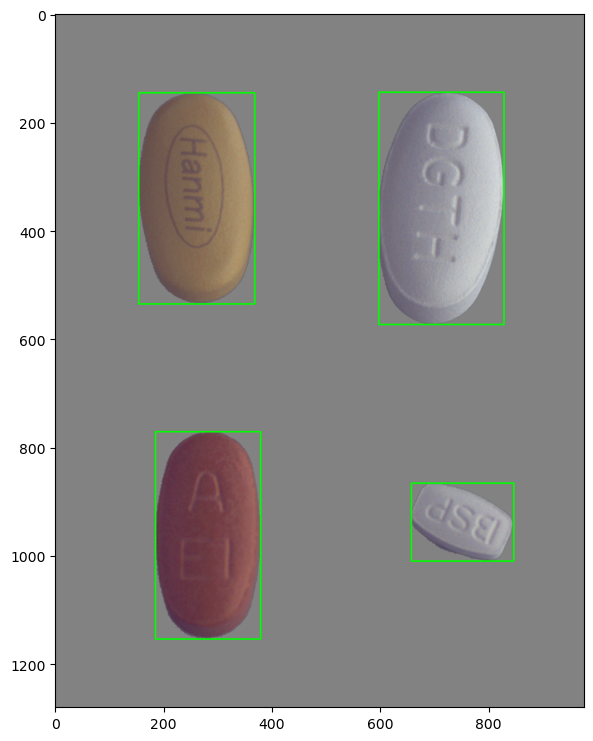

In [173]:
image_root='./ai06-level1-project/train_output'
image_name='K-001900-010224-016551-031705_0_2_0_2_70_000_200'
image=Image.open(os.path.join(image_root,image_name+'.png'))
image_cv=cv2.cvtColor(np.array(image), cv2.COLOR_RGBA2BGR)
pt1 = (154, 145)
pt2 = (368, 535)
cv2.rectangle(image_cv, pt1, pt2, (0, 256, 0), 2)
pt3 = (597, 144)
pt4 = (828, 573)
cv2.rectangle(image_cv, pt3, pt4, (0, 256, 0), 2)
pt5 = (185, 771)
pt6 = (379, 1154)
cv2.rectangle(image_cv, pt5, pt6, (0, 256, 0), 2)
pt7 = (657, 866)
pt8 = (846, 1010)
cv2.rectangle(image_cv, pt7, pt8, (0, 256, 0), 2)

fig, ax = plt.subplots(1, figsize=(12,9))
plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR))
plt.show()

# 데이터 라벨링 검토하기
우선 라벨링 파일을 호출하고, 이미지 단위로 라벨링 매핑 dictionary를 생성한다.</br>
그와 동시에, 클래스 id 별로 이미지 폴더를 만들어서 저장해준다.</br>
</br>
완료된 후, 잘린 이미지 중 라벨링 매핑의 key에 없는 것을 찾아서 추가로 매핑한다.</br>
또한, 클래스 id 별로 이미지 폴더를 검토한다.

In [174]:
# 잘린 이미지들이 위치한 폴더
image_root='./cropped_images'
class_id=0
labelling_map={}
class_count={}
count=0
# 라벨링 파일
with open('./label_mapping.txt','r') as f:
    # 첫 줄 무시
    f.readline()
    lines=f.readlines()
    for line in lines:
        print(count+1)
        count+=1
        # 이름과 라벨 사이에는 탭으로 구분했습니다.
        line=list(line.strip().split('\t'))
        # 라벨이 있다면 class_id를 갱신
        if len(line)==2:
            class_id=int(line[1])
            class_count[str(class_id)]=0
        # 현재 이미지의 라벨은 현재 class_id
        labelling_map[line[0]]=class_id
        class_count[str(class_id)]+=1
        # 현재 class_id에 해당하는 폴더가 없으면 생성
        os.makedirs(os.path.join('pill_images',str(class_id)),exist_ok=True)
        # 이미지를 해당 폴더로 복사
        os.system(f'cp {image_root}/{line[0]}.png ./pill_images/{str(class_id)}/{line[0]}.png')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [164]:
print(len(class_count.keys()))

74


이제 이미지 중 놓친 것이 있는지 확인한다.

In [143]:
images=os.listdir(image_root)
for image in images:
    if image[:-4] not in labelling_map.keys():
        print(image[:-4])

모든 파일에 대해 라벨링 및 검토를 마무리하였다.</br>
또한, 중간에 잘못 이름이 붙은 파일에 대해서도 수정을 해주었다.</br>
</br>
이제 각 클래스 별 이미지 수를 통해 불균형 여부를 파악한다.

<Axes: >

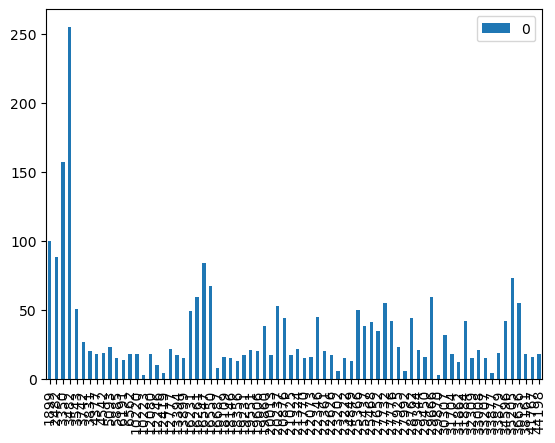

In [144]:
class_count_df=pd.DataFrame.from_dict(data=class_count,orient='index')
class_count_df.plot(kind='bar')

대충 봐도 불균형이 심각하니, 데이터를 추가하거나 증강을 할 필요가 있다.</br>
일단 여기서 일시 중단하고, 추가 데이터를 얻어서 위의 과정을 반복하겠다.</br>
그리고, 각 클래스 별로 종합적인 데이터 수를 구하고, 데이터 수가 가장 적은 클래스를 활용할 것이다.</br>
이 과정은 해당 시점에서 다시 설명하겠다.

# bbox 데이터를 annotation화하기
앞서 획득한 데이터는 YOLO 데이터로도 변환이 가능하다.</br>
이는 다음과 같이 이뤄진다.

- 각 원본 이미지에 대해 (배경을 지운 버전)
    - 해당 이미지의 각 bbox 데이터에서 '객체 별 id'와 'bbox 정보'를 얻는다.
    - '객체 별 id'를 사용하여, 라벨링 데이터에서 '해당 객체의 class id'를 얻는다. ('이미지 이름'_'객체 id')와 'class id'가 매핑되고 있기에 가능하다.
    - 이미지에 대한 id는 임의로 1번부터 시작한다.
    - annotation에 대한 id는 임의로 1번부터 시작한다.
    - 각 bbox에 대해
        - annotation id와 bbox를 annotation 데이터에 추가한다.
        - class id를 class 정보로 추가한다. supercategory는 전부 pill로 통일한다. (일단은)

위의 방법을 활용하여 다음과 같이 실행한다.

In [145]:
cat_id_to_name={
    1899: "보령부스파정 5mg",
    2482: "뮤테란캡슐 100mg",
    3350: "일양하이트린정 2mg",
    3482: "기넥신에프정(은행엽엑스)(수출용)",
    3543: "무코스타정(레바미피드)(비매품)",
    3742: "알드린정",
    3831: "뉴로메드정(옥시라세탐)",
    4377: "타이레놀정500mg",
    4542: "에어탈정(아세클로페낙)",
    5093: "삼남건조수산화알루미늄겔정",
    5885: "타이레놀이알서방정(아세트아미노펜)(수출용)",
    6191: "삐콤씨에프정 618.6mg/병",
    6562: "조인스정 200mg",
    10220: "쎄로켈정 100mg",
    10223: "넥시움정 40mg",
    12080: "리렉스펜정 300mg/PTP",
    12246: "아빌리파이정 10mg",
    12419: "자이프렉사정 2.5mg",
    12777: "다보타민큐정 10mg/병",
    13394: "써스펜8시간이알서방정 650mg",
    13899: "에빅사정(메만틴염산염)(비매품)",
    16231: "리피토정 20mg",
    16261: "크레스토정 20mg",
    16547: "가바토파정 100mg",
    16550: "동아가바펜틴정 800mg",
    16687: "오마코연질캡슐(오메가-3-산에틸에스테르90)",
    18109: "란스톤엘에프디티정 30mg",
    18146: "리리카캡슐 150mg",
    18356: "종근당글리아티린연질캡슐(콜린알포세레이트)",
    19231: "콜리네이트연질캡슐 400mg",
    19551: "트루비타정 60mg/병",
    19606: "스토가정 10mg",
    19860: "노바스크정 5mg",
    20013: "마도파정",
    20237: "플라빅스정 75mg",
    20876: "엑스포지정 5/160mg",
    21025: "펠루비정(펠루비프로펜)",
    21324: "아토르바정 10mg",
    21770: "라비에트정 20mg",
    22073: "리피로우정 20mg",
    22346: "자누비아정 50mg",
    22361: "맥시부펜이알정 300mg",
    22626: "메가파워정 90mg/병",
    23202: "쿠에타핀정 25mg",
    23222: "비타비백정 100mg/병",
    24849: "놀텍정 10mg",
    25366: "자누메트정 50/850mg",
    25437: "큐시드정 31.5mg/PTP",
    25468: "아모잘탄정 5/100mg",
    27652: "세비카정 10/40mg",
    27732: "트윈스타정 40/5mg",
    27776: "카나브정 60mg",
    27925: "울트라셋이알서방정",
    27992: "졸로푸트정 100mg",
    28762: "트라젠타정(리나글립틴)",
    29344: "비모보정 500/20mg",
    29450: "레일라정",
    29666: "리바로정 4mg",
    29870: "렉사프로정 15mg",
    30307: "트라젠타듀오정 2.5/850mg",
    31704: "낙소졸정 500/20mg",
    31862: "아질렉트정(라사길린메실산염)",
    31884: "자누메트엑스알서방정 100/1000mg",
    32309: "글리아타민연질캡슐",
    33008: "신바로정",
    33207: "에스원엠프정 20mg",
    33877: "브린텔릭스정 20mg",
    33879: "글리틴정(콜린알포세레이트)",
    34596: "제미메트서방정 50/1000mg",
    35205: "아토젯정 10/40mg",
    36636: "로수젯정10/5밀리그램",
    38161: "로수바미브정 10/20mg",
    41767: "카발린캡슐 25mg",
    44198: "케이캡정 50mg"
}

In [149]:
def parse_bbox_txt(txt_path,an_id,img_id,img_name):
    annotations = []
    categories = []
    with open(txt_path, "r", encoding="utf-8") as f:
        # 첫 줄 제거 - 이전 단계의 파일 형식에서 첫 줄은 인덱스
        f.readline()
        lines = f.read().strip().split("\n")
    a_id=an_id
    for idx, line in enumerate(lines):
        if ":" not in line:
            continue

        _, coords = line.split(":")
        x,y,w,h = map(int, coords.split(","))

        cat_id=labelling_map[img_name[:-4]+'_'+str(idx+1)]

        annotations.append({
            "id": a_id,
            "image_id": img_id,
            "category_id": cat_id,
            "bbox": [x, y, w, h],
            "area": w * h,
            "iscrowd": 0,
            "segmentation": []
        })
        a_id+=1

        categories.append({
            "id": cat_id,
            "supercategory": 'pill',
            "name": cat_id_to_name[cat_id]
        })
    return annotations, categories, a_id

In [150]:
def bbox_to_json(images_root='./ai06-level1-project/train_output',annotations_root='./ai06-level1-project/train_annotations'):
    pill_sets=os.listdir(annotations_root)
    annotation_id=1
    image_id=1
    cnt=0
    for pill_set in pill_sets:
        pill_set_path = os.path.join(annotations_root, pill_set)

        # *_bbox.txt 파일만 가져오기
        bbox_files = [f for f in os.listdir(pill_set_path) if f.endswith("_bbox.txt")]

        if len(bbox_files) == 0:
            continue
        
        new_json_dir = os.path.join(pill_set_path)

        # 각 이미지에 대해서
        for bbox_file in bbox_files:
            txt_path = os.path.join(pill_set_path, bbox_file)
            base_name = bbox_file[:-9]
            image_file_name = base_name + ".png"
            json_filename = base_name + ".json"
            json_path = os.path.join(new_json_dir, json_filename)

            # 이미지 크기를 구하기 위해 호출
            image=Image.open(os.path.join(images_root,image_file_name))
            W,H=image.size
            
            annotations,categories, a_id=parse_bbox_txt(txt_path,annotation_id,image_id,image_file_name)
            annotation_id=a_id

            coco_dict = {
                "images": [
                    {
                        "id": image_id,
                        "file_name": image_file_name,
                        "height": H,
                        "width": W
                    }
                ],
                "annotations": annotations,
                "categories": categories
            }

            image_id+=1
            with open(json_path, "w", encoding="utf-8") as f:
                json.dump(coco_dict, f, ensure_ascii=False, indent=4)

            cnt += 1
            print(cnt)

bbox_to_json(annotations_root='./ai06-level1-project/train_annotations')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


# 데이터 추가하기
이번 목표는 새로 이미지를 다운받고, 그 중 필요한 이미지만 선별하는 것이다.</br>
이는 '폴더 명'을 기준으로 수행하며, 폴더 명에서 필요한 알약 중 하나 이상의 코드를 가진 경우 이미지를 꺼낸다.</br>
이외의 폴더는 폴더 자체를 지운다.

In [52]:
additional_image_root='./additional_training_data/train_images'
folders=sorted(os.listdir(additional_image_root))

class_list=class_count.keys()

cond=False
for folder in folders:
    folder_path=os.path.join(additional_image_root,folder)
    if not os.path.isdir(folder_path):
        continue
    # 각 annotation 조합에 대해, 알약 목록을 구한다.
    pills=list(map(int,folder[2:].split('-')))

    # 이미지의 알약 중 하나라도 train_dataset에 있다면
    if any([str(pill-1) in class_list for pill in pills]):
        # 해당 폴더의 각 이미지에 대해서
        images=os.listdir(folder_path)
        for image in images:
            # 이미지 경로를 구한다.
            image_path=os.path.join(folder_path,image)
            # index 이미지는 지운다.
            if 'index' not in str(image_path):
                shutil.move(image_path, os.path.join(additional_image_root, image))
    # 폴더 및 폴더에 남은 이미지들은 지운다.
    os.system(f'rm -rf {folder_path}')

그 뒤, 추가 데이터의 이미지들을 잘라서 저장한다.</br>
물론, 그 전에 데이터의 이미지들에서 배경을 지워야 한다.

In [148]:
bbox_from_image(images_path='./additional_training_data/train_cleaned',annotations_path='./additional_training_data/train_annotations')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [198]:
image_crop_with_bbox(annotation_root='./additional_training_data/train_annotations',image_root='./additional_training_data/train_cleaned',crop_path='./additional_cropped_images/')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


# 추가 데이터 라벨링하기
이번에는 수작업이 아니라, DINOv2 모델을 사용해보겠다.</br>
기존 데이터를 작업하던 시점에서는 데이터가 부족한 클래스들이 있어 적용하기 어려웠다.</br>
지금은 추가 데이터가 충분히 있어 대표 이미지를 적당히 고를 수 있기에 적용이 가능하다.

In [183]:
import numpy as np
import torch
import torchvision.transforms.v2 as T

model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
model.eval()

Using cache found in /home/codeitDev/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affi

In [191]:
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

/home/codeitDev/miniconda3/envs/codeit/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [192]:
def get_embedding(img_path):
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0)

    with torch.no_grad():
        feat = model(x)

    return feat.squeeze().numpy()

우선, 임베딩용 대표 이미지를 넣을 폴더를 생성한다.</br>
이미지는 폴더 당 10개 정도로 넣는다.</br>
만약 기존 데이터만으로 부족하면 새 데이터에서 직접 찾아서 채워 넣어줘야 한다.

In [243]:
base_dir = "./base_data"
dist='./additional_pill_images'
if not os.path.isdir(dist):
    os.makedirs(dist)
if not os.path.isdir(base_dir):
    os.makedirs(base_dir)
for c in class_count.keys():
    os.makedirs(os.path.join(base_dir, c), exist_ok=True)
    os.makedirs(os.path.join(dist, c), exist_ok=True)

이제 임베딩 벡터를 만든다.

In [194]:
class_embeddings = {}

for cls in os.listdir(base_dir):
    cls_dir = os.path.join(base_dir, cls)
    feats = []
    for img in os.listdir(cls_dir):
        path = os.path.join(cls_dir, img)
        feats.append(get_embedding(path))
    class_embeddings[cls] = np.mean(feats, axis=0)


In [236]:
from sklearn.metrics.pairwise import cosine_similarity

def classify(img_path,allowed_classes=None):
    feat = get_embedding(img_path).reshape(1, -1)

    if np.isnan(feat).any():
        raise ValueError(f"NaN in embedding for {img_path}")
    
    sims = {}

    # 비교할 클래스 목록을 확인 / 없으면 전체 클래스 중에서 예측
    if allowed_classes is None:
        classes_to_check = class_embeddings.keys()
    else:
        classes_to_check = allowed_classes

    for cls in classes_to_check:
        proto = class_embeddings[cls]

        sim = cosine_similarity(feat, proto.reshape(1, -1))[0][0]
        sims[cls] = sim
    return max(sims, key=sims.get), sims

In [196]:
for cls, proto in class_embeddings.items():
    if np.isnan(proto).any():
        print("NaN in class prototype:", cls)


마지막으로, 예측 값을 각 이미지마다 얻은 뒤에 폴더에 저장하는 코드를 만든다.

In [ ]:
need_predict='./additional_cropped_images'
dist='./additional_pill_images'
images=os.listdir(need_predict)
not_found=[]
cnt=0
class_list=class_count.keys()
for image in images:
    print(cnt+1)
    cnt+=1
    # print(image)
    classes=list(map(int,image[2:-25].split('-')))
    classes=[str(c-1) for c in classes if str(c-1) in class_list]
    image_path=os.path.join(need_predict,image)
    label, scores = classify(image_path,classes)

    # print("Predicted:", label)
    # print(scores)
    if scores[label]>0.9:
        shutil.copy(image_path, os.path.join(dist, label, image))
    else:
        not_found.append(image)
    #print(scores)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245


# 추가 데이터 라벨링 검토하기
라벨링 파일을 검토한 뒤 보완</br>
후에 라벨링 파일을 기준으로 기본 데이터와 동일한 방법으로 알약 별 폴더에 정리

In [154]:
# 잘린 이미지들이 위치한 폴더
image_root='./additional_cropped_images'
class_id=0
labelling_map={}
class_count={}
count=0
# 라벨링 파일
with open('./additional_label_mapping.txt','r') as f:
    # 첫 줄 무시
    f.readline()
    lines=f.readlines()
    for line in lines:
        print(count+1)
        count+=1
        # 이름과 라벨 사이에는 탭으로 구분했습니다.
        line=list(line.strip().split('\t'))
        # 라벨이 있다면 class_id를 갱신
        if len(line)==2:
            class_id=int(line[1])
            class_count[str(class_id)]=0
        # 현재 이미지의 라벨은 현재 class_id
        labelling_map[line[0]]=class_id
        class_count[str(class_id)]+=1
        # 현재 class_id에 해당하는 폴더가 없으면 생성
        os.makedirs(os.path.join('additional_pill_images',str(class_id)),exist_ok=True)
        # 이미지를 해당 폴더로 복사
        os.system(f'cp {image_root}/{line[0]}.png ./additional_pill_images/{str(class_id)}/{line[0]}.png')

1
2
3
4
5
6
7
8
9
10
11


# 추가 데이터 bbox를 annotation화하기

# 분류기 학습 및 예측하기
각 이미지 조각에 대해, 분류기를 통해 학습을 시킨다.</br>
학습이 완료되면, 앞서 train 데이터에 적용한 방법을 사용하여 test 데이터를 생성한다.</br>
분류기를 통해, test 데이터의 이미지들에 대해 분류를 수행한다.

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn

num_classes = 56

이제 데이터셋을 준비한다.

In [28]:
annotation_root='./ai06-level1-project/train_annotations'
annotations=sorted(os.listdir(annotation_root))

image_root='./ai06-level1-project/train_output'

code=[]
images = os.listdir(image_root)
for i in images:
    i=i[2:-23]
    codes=list(map(int,i.split('-')))
    code.extend(codes)

code=sorted(list(set(code)))
code

[1900,
 2483,
 3351,
 3483,
 3544,
 3743,
 3832,
 4378,
 4543,
 5094,
 5886,
 6192,
 6563,
 10221,
 10224,
 12081,
 12247,
 12420,
 12778,
 13395,
 13900,
 16232,
 16262,
 16548,
 16551,
 16688,
 18110,
 18147,
 18357,
 19232,
 19552,
 19607,
 19861,
 20014,
 20238,
 20877,
 21026,
 21325,
 21771,
 22074,
 22347,
 22362,
 22627,
 23203,
 23223,
 24850,
 25367,
 25438,
 25469,
 27653,
 27733,
 27777,
 27926,
 27993,
 28763,
 29345,
 29451,
 29667,
 29871,
 30308,
 31705,
 31863,
 31885,
 32310,
 33009,
 33208,
 33878,
 33880,
 34597,
 35206,
 36637,
 38162,
 41768,
 44199]

In [ ]:
len(code)

그리고, 모델을 준비해준다.

In [ ]:
# 백본만 사전학습된 상태로 로드
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# 분류기 헤드 교체
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

# YOLO 학습하기
앞서 만들었던 bbox 데이터를 활용하여 YOLO 학습용 annotation 파일들을 만든다.</br>
그 파일들을 이용하여 YOLO 학습용 dataset을 만든 뒤 적용한다.